# Company

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import requests
import datetime
import time
from random import uniform, randint

## Data load

In [2]:
companies_df = pd.read_parquet('../Data/NER/comp_data_after_ner_5years.parquet')

## Downloading data from Moscow Exchange and enriching the existing dataset

In [3]:
companies_string = 'http://iss.moex.com/iss/engines/stock/markets/shares/securities/{}/candles.json?from={}&till={}&interval=1'

In [4]:
companies_df['price_release'] = np.nan
companies_df['volume_release'] = np.nan
companies_df['price_lag_30'] = np.nan
companies_df['volume_lag_30'] = np.nan

In [5]:
companies_df = companies_df.sort_values(by=['datetime'])

In [6]:
for i in tqdm(range(len(companies_df))):
    start = companies_df['datetime'][i]
    end = companies_df['datetime'][i] + datetime.timedelta(minutes=30)
    company = companies_df['company'][i]
    connect_timeout = 300
    read_timeout = 120
    n = requests.get(companies_string.format(company, start, end),
                     timeout=(connect_timeout, read_timeout)).json()
    try:
        companies_df.loc[i, 'price_release'] = n['candles']['data'][0][0]
        companies_df.loc[i, 'volume_release'] = n['candles']['data'][0][4]
        companies_df.loc[i, 'price_lag_30'] = n['candles']['data'][-1][0]
        companies_df.loc[i, 'volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
#     if i % randint() == 0:
#         delay = uniform(5, 10)
#         time.sleep(delay)

  0%|          | 0/57968 [00:00<?, ?it/s]

In [7]:
companies_df.isna().sum()

website              0
section              0
url                  0
header               0
body                 0
key_words          231
body_length          0
datetime             0
company              0
price_release     7677
volume_release    7677
price_lag_30      7677
volume_lag_30     7677
dtype: int64

> **Comment:** We have 7677 NAs, this is due to the fact that in previous years some instruments didn't have evening sessions, or some instruments were not listed yet, or there were some issues with MOEX. We can’t do anything about this, so we just removed these observations

In [63]:
companies_df = companies_df.dropna(subset=['price_release']).reset_index(drop=True)

In [66]:
companies_df

,website,section,url,header,body,key_words,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,SBER,189.480000,9115201.2,189.41000,7706400.2
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,VTBR,0.034145,2040965.3,0.03417,16743.5
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,AFLT,101.240000,135675.4,101.20000,190179.4
3,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,SBER,189.400000,3002168.7,189.66000,1251247.1
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,GAZP,155.840000,395898.8,156.12000,1089754.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50286,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974713.php,🔶IR Газпром: Группа «Газпром» консолидировала ...,Релиз\n\nГруппа «Газпром» консолидировала конт...,"[Газпром, пресс релиз]",598,2023-12-29 18:14:00,GAZP,159.880000,2880999.8,159.81000,8380722.5
50287,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938575,"ГПБ стал совладельцем завода СПГ ""Газпрома"" у ...","- Группа ""Газпромбанка"" стала совладельцем с...","[Газпромбанк, Газпром, Ленинградская область, ...",1218,2023-12-29 18:17:00,GAZP,159.890000,3022553.7,159.89000,599587.5
50288,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938588,Сооснователь Fix Price Хачатрян продал свою до...,- Сооснователь Fix Price Артем Хачатрян выше...,"[Fix Price, Артем Хачатрян]",1302,2023-12-29 19:24:00,FIXP,280.700000,398994.5,286.10000,156730.0
50289,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,QIWI,566.500000,210171.5,564.00000,691464.0


## Getting the differences

In [68]:
companies_df['price_diff'] = companies_df['price_lag_30'] - companies_df['price_release']
companies_df['price_diff_percent'] = companies_df['price_diff'] / companies_df['price_release'] * 100
companies_df['volume_diff'] = companies_df['volume_lag_30'] - companies_df['volume_release']
companies_df['volume_diff_percent'] = companies_df['volume_diff'] / companies_df['volume_release'] * 100

## Some observations

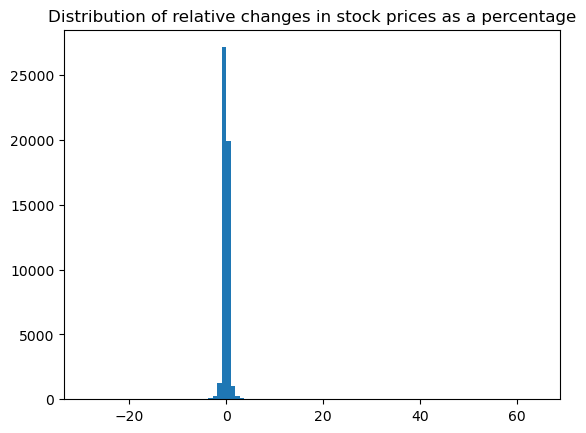

In [69]:
plt.hist(companies_df.price_diff_percent, bins=100)
plt.title('Distribution of relative changes in stock prices as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

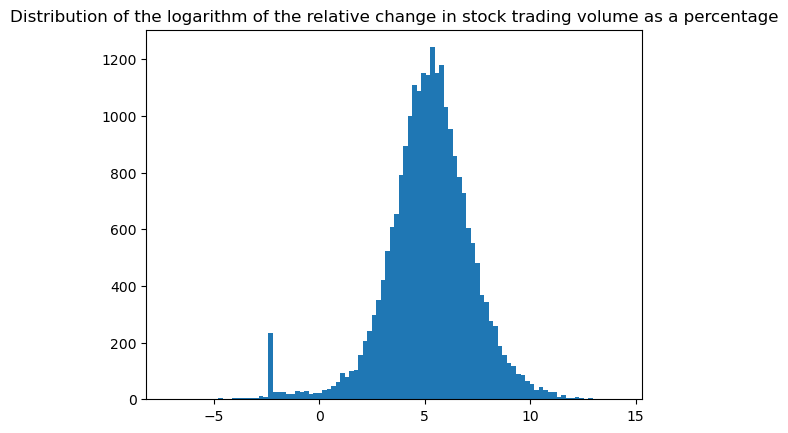

In [72]:
plt.hist(np.log(companies_df.volume_diff_percent+0.1), bins=100)
plt.title('Distribution of the logarithm of the relative change in stock trading volume as a percentage')
plt.show()

> **Comment:** We found that the relative change in stock trading volume has approximately a log-normal distribution

## Export and Check

In [73]:
companies_df.to_parquet('../Data/MOEX/comp_data_after_moex_5years.parquet')

In [74]:
pd.read_parquet('../Data/MOEX/comp_data_after_moex_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,SBER,189.480000,9115201.2,189.41000,7706400.2,-0.070000,-0.036943,-1408801.0,-15.455512
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,VTBR,0.034145,2040965.3,0.03417,16743.5,0.000025,0.073217,-2024221.8,-99.179628
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,AFLT,101.240000,135675.4,101.20000,190179.4,-0.040000,-0.039510,54504.0,40.172353
3,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,SBER,189.400000,3002168.7,189.66000,1251247.1,0.260000,0.137276,-1750921.6,-58.321892
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,GAZP,155.840000,395898.8,156.12000,1089754.1,0.280000,0.179671,693855.3,175.260774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50286,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974713.php,🔶IR Газпром: Группа «Газпром» консолидировала ...,Релиз\n\nГруппа «Газпром» консолидировала конт...,"[Газпром, пресс релиз]",598,2023-12-29 18:14:00,GAZP,159.880000,2880999.8,159.81000,8380722.5,-0.070000,-0.043783,5499722.7,190.896324
50287,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938575,"ГПБ стал совладельцем завода СПГ ""Газпрома"" у ...","- Группа ""Газпромбанка"" стала совладельцем с...","[Газпромбанк, Газпром, Ленинградская область, ...",1218,2023-12-29 18:17:00,GAZP,159.890000,3022553.7,159.89000,599587.5,0.000000,0.000000,-2422966.2,-80.162883
50288,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938588,Сооснователь Fix Price Хачатрян продал свою до...,- Сооснователь Fix Price Артем Хачатрян выше...,"[Fix Price, Артем Хачатрян]",1302,2023-12-29 19:24:00,FIXP,280.700000,398994.5,286.10000,156730.0,5.400000,1.923762,-242264.5,-60.718757
50289,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,QIWI,566.500000,210171.5,564.00000,691464.0,-2.500000,-0.441306,481292.5,228.999888


# Industry

## Data import

In [8]:
ind_df = pd.read_parquet('../Data/NER/ind_data_after_ner_5years.parquet')

## Downloading data from Moscow Exchange and enriching the existing dataset

In [10]:
ind_string = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/SNDX/securities/{}/candles.json?from={}&till={}&interval=1'

In [11]:
ind_df['price_release'] = np.nan
ind_df['volume_release'] = np.nan
ind_df['price_lag_30'] = np.nan
ind_df['volume_lag_30'] = np.nan

In [12]:
ind_df = ind_df.sort_values(by=['datetime'])

In [14]:
for i in tqdm(range(len(ind_df))):
    start = ind_df['datetime'][i]
    end = ind_df['datetime'][i] + datetime.timedelta(minutes=30)
    ind = ind_df['industry'][i]
    connect_timeout = 100000
    read_timeout = 100000
    n = requests.get(ind_string.format(ind, start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        ind_df.loc[i, 'price_release'] = n['candles']['data'][0][0]
        ind_df.loc[i, 'volume_release'] = n['candles']['data'][0][4]
        ind_df.loc[i, 'price_lag_30'] = n['candles']['data'][-1][0]
        ind_df.loc[i, 'volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
#     delay = uniform(0, 3)
#     time.sleep(delay)

  0%|          | 0/48270 [00:00<?, ?it/s]

In [15]:
ind_df.isna().sum()

website               0
section               0
url                   0
header                0
body                  0
key_words           158
body_length           0
datetime              0
industry              0
price_release     12431
volume_release    12431
price_lag_30      12431
volume_lag_30     12431
dtype: int64

> **Comment:** We got 12431 NAs, this is due to the fact that, unlike other instruments that we consider, industrial indices have a narrower time window for trading, as a result, a significant part of the observations in our sample are not suitable, since these observations do not fall into this window. We can’t do anything about this, so we just remove these observations

In [82]:
ind_df = ind_df.dropna(subset=['price_release']).reset_index(drop=True)

In [84]:
ind_df

,website,section,url,header,body,key_words,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXFN,5640.75,1.415923e+07,5648.09,8185011.30
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXTN,1439.71,1.346630e+05,1439.51,191191.40
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,MOEXFN,5647.38,3.654676e+06,5648.31,1770152.15
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,MOEXOG,6981.18,3.336782e+06,6998.57,13124922.10
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00,MOEXFN,5660.76,2.029958e+06,5665.35,13453242.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35834,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974710.php,Авторы иска к Ивлеевой потребовали от МТС комп...,Авторы коллективного иска к Ивлеевой на 1 млрд...,"[мтс, исковое заявление, ивлеева, акции]",390,2023-12-29 18:08:00,MOEXTL,1786.17,6.878507e+05,1784.93,1801842.20
35835,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938576,"""Газпром"" консолидировал контроль в ""Газпром-М...",ГПБ остается миноритарием\nМосква. 29 декабря....,[Газпром],622,2023-12-29 18:13:00,MOEXOG,8854.32,2.644813e+07,8848.47,4899864.60
35836,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974713.php,🔶IR Газпром: Группа «Газпром» консолидировала ...,Релиз\n\nГруппа «Газпром» консолидировала конт...,"[Газпром, пресс релиз]",598,2023-12-29 18:14:00,MOEXOG,8852.76,1.434688e+07,8848.47,4899864.60
35837,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938575,"ГПБ стал совладельцем завода СПГ ""Газпрома"" у ...","- Группа ""Газпромбанка"" стала совладельцем с...","[Газпромбанк, Газпром, Ленинградская область, ...",1218,2023-12-29 18:17:00,MOEXOG,8851.24,7.629381e+06,8848.47,4899864.60


## Getting the differences

In [85]:
ind_df['price_diff'] = ind_df['price_lag_30'] - ind_df['price_release']
ind_df['price_diff_percent'] = ind_df['price_diff'] / ind_df['price_release'] * 100
ind_df['volume_diff'] = ind_df['volume_lag_30'] - ind_df['volume_release']
ind_df['volume_diff_percent'] = ind_df['volume_diff'] / ind_df['volume_release'] * 100

## Some observations

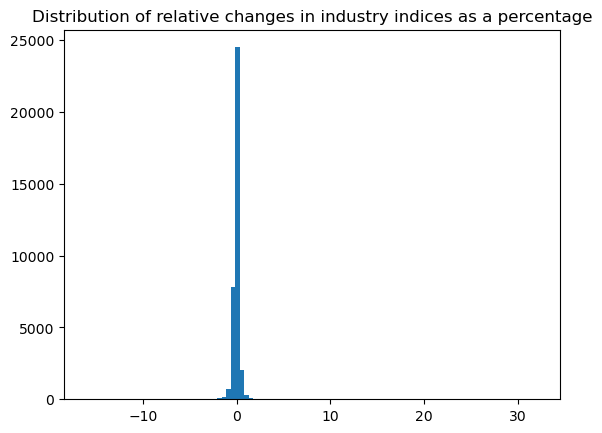

In [86]:
plt.hist(ind_df.price_diff_percent, bins=100)
plt.title('Distribution of relative changes in industry indices as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

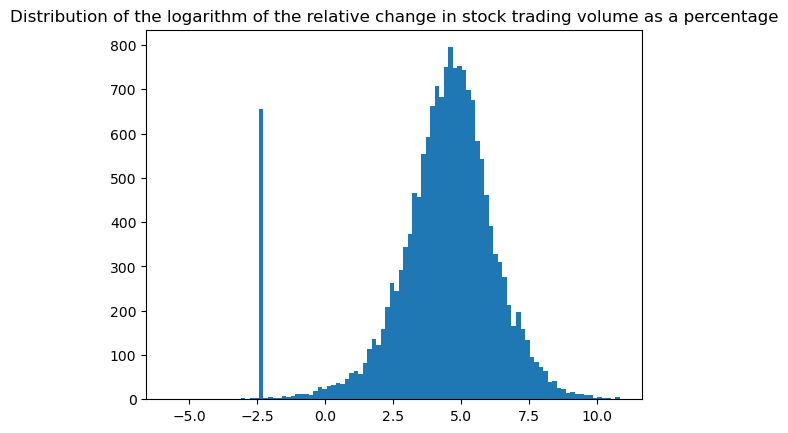

In [102]:
plt.hist(np.log(ind_df.volume_diff_percent.sort_values()[:-45]+0.1), bins=100)
plt.title('Distribution of the logarithm of the relative change in stock trading volume as a percentage')
plt.show()

> **Comment:** We found that the relative change in stock trading volume has approximately a log-normal distribution

## Export and Check

In [104]:
ind_df.to_parquet('../Data/MOEX/ind_data_after_moex_5years.parquet')

In [105]:
pd.read_parquet('../Data/MOEX/ind_data_after_moex_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXFN,5640.75,1.415923e+07,5648.09,8185011.30,7.34,0.130125,-5.974218e+06,-42.193103
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXTN,1439.71,1.346630e+05,1439.51,191191.40,-0.20,-0.013892,5.652840e+04,41.977678
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,MOEXFN,5647.38,3.654676e+06,5648.31,1770152.15,0.93,0.016468,-1.884524e+06,-51.564728
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,MOEXOG,6981.18,3.336782e+06,6998.57,13124922.10,17.39,0.249098,9.788140e+06,293.340724
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00,MOEXFN,5660.76,2.029958e+06,5665.35,13453242.30,4.59,0.081085,1.142328e+07,562.734844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35834,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974710.php,Авторы иска к Ивлеевой потребовали от МТС комп...,Авторы коллективного иска к Ивлеевой на 1 млрд...,"[мтс, исковое заявление, ивлеева, акции]",390,2023-12-29 18:08:00,MOEXTL,1786.17,6.878507e+05,1784.93,1801842.20,-1.24,-0.069422,1.113992e+06,161.952514
35835,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938576,"""Газпром"" консолидировал контроль в ""Газпром-М...",ГПБ остается миноритарием\nМосква. 29 декабря....,[Газпром],622,2023-12-29 18:13:00,MOEXOG,8854.32,2.644813e+07,8848.47,4899864.60,-5.85,-0.066069,-2.154826e+07,-81.473679
35836,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974713.php,🔶IR Газпром: Группа «Газпром» консолидировала ...,Релиз\n\nГруппа «Газпром» консолидировала конт...,"[Газпром, пресс релиз]",598,2023-12-29 18:14:00,MOEXOG,8852.76,1.434688e+07,8848.47,4899864.60,-4.29,-0.048459,-9.447017e+06,-65.847180
35837,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938575,"ГПБ стал совладельцем завода СПГ ""Газпрома"" у ...","- Группа ""Газпромбанка"" стала совладельцем с...","[Газпромбанк, Газпром, Ленинградская область, ...",1218,2023-12-29 18:17:00,MOEXOG,8851.24,7.629381e+06,8848.47,4899864.60,-2.77,-0.031295,-2.729516e+06,-35.776380


# MOEX, RVI and RUNUSD futures

## Data import

In [14]:
global_df = pd.read_parquet('../Data/NER/glob_data_after_ner_5years.parquet')

## Downloading data from Moscow Exchange and enriching the existing dataset

In [15]:
global_moex = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/SNDX/securities/{}/candles.json?from={}&till={}&interval=1'
global_rvi = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/RTSI/securities/RVI/candles.json?from={}&till={}&interval=1'
global_usd_rub_fut = 'http://iss.moex.com/iss/engines/futures/markets/forts/boards/RFUD/securities/{}/candles.json?from={}&till={}&interval=1'

In [16]:
global_df['imoex_price_release'] = np.nan
global_df['imoex_price_lag_30'] = np.nan

global_df['rvi_price_release'] = np.nan
global_df['rvi_price_lag_30'] = np.nan

global_df['usd_price_release'] = np.nan
global_df['usd_price_lag_30'] = np.nan

In [17]:
global_df = global_df.sort_values(by=['datetime'])

In [18]:
def third_thursday(year, month):
    """Return datetime.date for monthly option expiration given year and
    month
    """
    # The 15th is the lowest third day in the month
    third = datetime.date(year, month, 15)
    # What day of the week is the 15th?
    w = third.weekday()
    # Thursday is weekday 3
    if w != 3:
        # Replace just the day (of month)
        third = third.replace(day=(15 + (3 - w) % 7))
    return third

In [1]:
for i in tqdm(range(len(global_df))):
    time.sleep(0.1)
    
    start = global_df['datetime'][i]
    end = global_df['datetime'][i] + datetime.timedelta(minutes=30)
    connect_timeout = 300
    read_timeout = 120
    if str(start.time()) < '18:35:00':
        n = requests.get(global_moex.format('IMOEX', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'imoex_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'imoex_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'imoex_price_release'] = np.nan
            global_df.loc[i, 'imoex_price_lag_30'] = np.nan
    elif str(start.time()) < '18:50:00':
        n = requests.get(global_moex.format('IMOEX', start, start + datetime.timedelta(minutes=1)), timeout=(connect_timeout, read_timeout) ).json()
        n_2 = requests.get(global_moex.format('IMOEX2', end, end + datetime.timedelta(minutes=1)), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'imoex_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'imoex_price_lag_30'] = n_2['candles']['data'][0][0]
        except IndexError:
            global_df.loc[i, 'imoex_price_release'] = np.nan
            global_df.loc[i, 'imoex_price_lag_30'] = np.nan
    else:
        n = requests.get(global_moex.format('IMOEX2', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'imoex_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'imoex_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'imoex_price_release'] = np.nan
            global_df.loc[i, 'imoex_price_lag_30'] = np.nan
            
    n = requests.get(global_rvi.format(start, end), timeout=(connect_timeout, read_timeout) ).json()
    try:
        global_df.loc[i, 'rvi_price_release'] = n['candles']['data'][0][0]
        global_df.loc[i, 'rvi_price_lag_30'] = n['candles']['data'][-1][0]
    except IndexError:
        global_df.loc[i, 'rvi_price_release'] = np.nan
        global_df.loc[i, 'rvi_price_lag_30'] = np.nan
    
    year = start.year
    if str(start) < f'{year}-03-{third_thursday(year, 3)}':
        n = requests.get(global_usd_rub_fut.format(f'SiH{year % 10}', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'usd_price_release'] = np.nan
            global_df.loc[i, 'usd_price_lag_30'] = np.nan
    elif str(start) < f'{year}-06-{third_thursday(year, 3)}':
        n = requests.get(global_usd_rub_fut.format(f'SiM{year % 10}', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'usd_price_release'] = np.nan
            global_df.loc[i, 'usd_price_lag_30'] = np.nan
    elif str(start) < f'{year}-09-{third_thursday(year, 3)}':
        n = requests.get(global_usd_rub_fut.format(f'SiU{year % 10}', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'usd_price_release'] = np.nan
            global_df.loc[i, 'usd_price_lag_30'] = np.nan
    elif str(start) < f'{year}-12-{third_thursday(year, 3)}':
        n = requests.get(global_usd_rub_fut.format(f'SiZ{year % 10}', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'usd_price_release'] = np.nan
            global_df.loc[i, 'usd_price_lag_30'] = np.nan
    else:
        n = requests.get(global_usd_rub_fut.format(f'SiH{((year + 1) % 10)}', start, end), timeout=(connect_timeout, read_timeout) ).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            global_df.loc[i, 'usd_price_release'] = np.nan
            global_df.loc[i, 'usd_price_lag_30'] = np.nan
#     delay = randint(1,2)
#     time.sleep(delay)


In [23]:
global_df.isna().sum()

website                   0
section                   0
url                       0
header                    0
body                      0
key_words               216
body_length               0
datetime                  0
imoex_price_release    7823
imoex_price_lag_30     7823
rvi_price_release      2135
rvi_price_lag_30       2135
usd_price_release      4818
usd_price_lag_30       4818
dtype: int64

> **Comment:** All three instruments have NAs in different periods due to their specific, that is why we will not drop any NA's in order not to loose observations for other instruments

## Getting the differences

In [27]:
global_df['imoex_price_diff'] = global_df['imoex_price_lag_30'] - global_df['imoex_price_release']
global_df['imoex_price_diff_percent'] = global_df['imoex_price_diff'] / global_df['imoex_price_release'] * 100

global_df['rvi_price_diff'] = global_df['rvi_price_lag_30'] - global_df['rvi_price_release']
global_df['rvi_price_diff_percent'] = global_df['rvi_price_diff'] / global_df['rvi_price_release'] * 100

global_df['usd_price_diff'] = global_df['usd_price_lag_30'] - global_df['usd_price_release']
global_df['usd_price_diff_percent'] = global_df['usd_price_diff'] / global_df['usd_price_release'] * 100

## Some observations

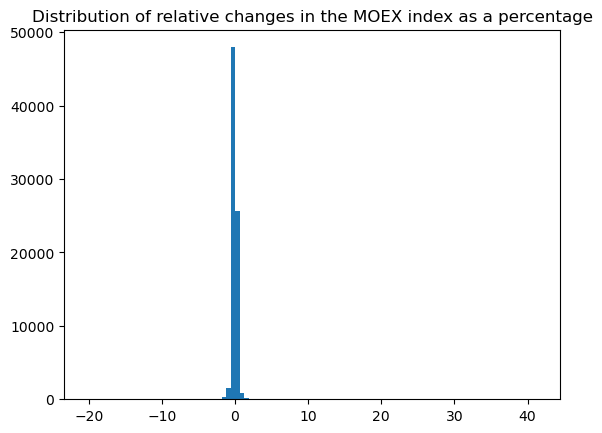

In [31]:
plt.hist(global_df.imoex_price_diff_percent, bins=100)
plt.title('Distribution of relative changes in the MOEX index as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

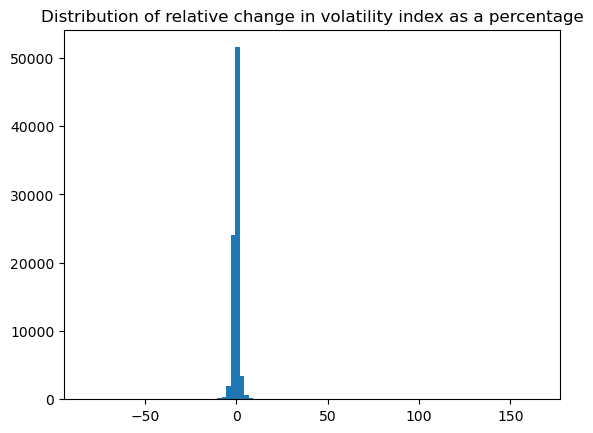

In [32]:
plt.hist(global_df.rvi_price_diff_percent, bins=100)
plt.title('Distribution of relative change in volatility index as a percentage')
plt.show()

> **Comment:** The distribution turned out to be almost symmetrical (though with some very small outliers) and with a very strong kurtosis at zero

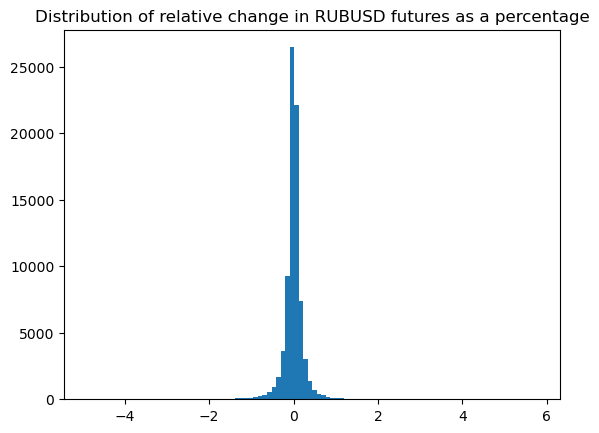

In [33]:
plt.hist(global_df.usd_price_diff_percent, bins=100)
plt.title('Distribution of relative change in RUBUSD futures as a percentage')
plt.show()

> **Comment:** It is easy to see that the distribution turned out to be quite logical: symmetrical and with a strong kurtosis at zero

> **P.S.** We took futures because it has a wider trading window than spot RUBUSD

## Export and Check

In [34]:
global_df.to_parquet('../Data/MOEX/glob_data_after_moex_5years.parquet')

In [35]:
pd.read_parquet('../Data/MOEX/glob_data_after_moex_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime,imoex_price_release,imoex_price_lag_30,rvi_price_release,rvi_price_lag_30,usd_price_release,usd_price_lag_30,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644976,Рынок акций РФ открылся снижением индексов Мос...,- Рынок акций РФ на первых в новом году торг...,[рынок акций],1961,2019-01-03 10:18:00,2354.11,2363.56,27.60,27.52,70212.0,69873.0,9.45,0.401426,-0.08,-0.289855,-339.0,-0.482823
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,2367.57,2369.30,27.47,27.50,69681.0,69773.0,1.73,0.073071,0.03,0.109210,92.0,0.132030
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,2369.28,2371.97,27.50,27.56,69792.0,69795.0,2.69,0.113537,0.06,0.218182,3.0,0.004298
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,2371.57,2376.33,27.55,27.84,69793.0,69774.0,4.76,0.200711,0.29,1.052632,-19.0,-0.027223
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00,2380.98,2383.72,28.13,28.30,69646.0,69600.0,2.74,0.115079,0.17,0.604337,-46.0,-0.066048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84516,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,3095.72,3095.74,28.75,28.77,91870.0,91938.0,0.02,0.000646,0.02,0.069565,68.0,0.074018
84517,Kommersant,Финансы,https://www.kommersant.ru/doc/6440789,ЦБ изучит связанные с криптоактивами трансгран...,Банк России планирует в начале 2024 года изучи...,[],1529,2023-12-29 20:52:00,3096.68,3095.20,28.69,28.76,91977.0,91964.0,-1.48,-0.047793,0.07,0.243987,-13.0,-0.014134
84518,Ria,Экономика,https://ria.ru/20231229/ssha-1919057051.html,"В США призвали ставить маячки на оборудование,...",Два американских эксперта в статье для New Y...,"[Экономика, Китай, США, Технологии, Россия, Ap...",1773,2023-12-29 21:00:00,3095.96,3095.84,28.69,28.83,91928.0,91887.0,-0.12,-0.003876,0.14,0.487975,-41.0,-0.044600
84519,Ria,Экономика,https://ria.ru/20231229/kapital-1919057431.html,"Глава ""Иннопрактики"" и ее первый зам вошли в к...","Глава российского института развития ""Иннопр...","[Экономика, Технологии, Россия, Наталия Попова...",2063,2023-12-29 21:01:00,3095.82,3095.75,28.71,28.82,91961.0,91861.0,-0.07,-0.002261,0.11,0.383142,-100.0,-0.108742
